In [1]:
from bitarray import bitarray
import random
import numpy as np
import math
import timeit

In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K

/Users/aditijain/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/aditijain/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/aditijain/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/aditijain/opt/anaconda3/lib/python3.7/site-packages

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix

In [4]:
import pandas as pd
import os

In [5]:
import sklearn.datasets as skds
from sklearn.datasets import fetch_openml

In [6]:
X, y = skds.fetch_openml("diabetes", return_X_y=True)
X = StandardScaler().fit_transform(X)


/Users/aditijain/opt/anaconda3/lib/python3.7/site-packages/sklearn/datasets/_openml.py:372: UserWarning: Multiple active versions of the dataset matching the name diabetes exist. Versions may be fundamentally different, returning version 1.
  " {version}.".format(name=name, version=res[0]['version']))


In [7]:
y[y==['tested_positive']] = 1
y[y==['tested_negative']] = 0

In [8]:
x_neg=X[y==0]
x_pos=X[y==1]
y_pos=y[y==1]
y_neg=y[y==0]
np.random.shuffle(x_neg)
print(x_neg.shape)
print(x_pos.shape)

(500, 8)
(268, 8)


In [9]:
indices=np.arange(250)
#x_train=np.array(x_neg[0:106])[indices]
y_train=y_neg[0:250]
x_train=np.concatenate((np.array(x_neg[0:250])[indices],x_pos)).reshape(-1,8)
y_train=np.concatenate((y_train,y_pos)).reshape(-1,1)

In [10]:
x_test = x_neg[250:500].reshape(-1,8)
y_test = y_neg[250:500].reshape(-1,1)

# Standard Bloom Filter

In [11]:
from bitarray import bitarray
import mmh3
import random
import numpy as np
import math

In [12]:
class BloomFilter:
    
    def __init__(self, size, hash_count):
        self.size = size
        self.hash_count = hash_count
        self.bit_array = bitarray(size)
        self.bit_array.setall(0)
        
    def add(self, num):
        for seed in range(1,self.hash_count+1):
            result = mmh3.hash(str(num), seed) % self.size
            self.bit_array[result] = 1
            
    def lookup(self, num):
        for seed in range(1,self.hash_count+1):
            result = mmh3.hash(str(num), seed) % self.size
            if self.bit_array[result] == 0:
                return False
        return True

# Projection model

In [13]:
class Projection_BloomFilter:
    def __init__(self, size, hash_count, dim):
        vectors = np.random.normal(0,1,size=(hash_count,dim)) #random vectors(each row) from normal distribution, not unit vectors
        i=0
        while(i<hash_count):
            if(vectors[i][0]<0):
                vectors[i][0] *= -1
               # print("initial v", vectors[i])
                #vectors[i]=np.random.normal(0,1,size=(1,dim))
                #print("changed v", vectors[i])
            i = i+1
       # print(vectors)        
        self.unit_vectors = np.transpose(vectors/np.sqrt(np.transpose([np.sum(np.multiply(vectors,vectors),1)]))) #Matrix where each column is a unit vector, used as hash
        self.size = size
        self.hash_count = hash_count
        self.bit_array = bitarray(size)
        self.bit_array.setall(0)

    def give_hash_values(self,X):
        projections = np.dot(X,self.unit_vectors) #Projections of datapoints on unit vectors
        norm_proj = 1/(1+np.exp(-projections)) #Sigmoid on each value so that they are in the range (0,1)
        hash_values = (norm_proj*(self.size-1)).astype(int) #All values are integers in the range [0,size-1]
        return hash_values                        #Each row contains hash values of that datapoint

    def add(self,x):
        hash_values = self.give_hash_values(x)
        for i in hash_values:
            self.bit_array[i] = 1
        
    def bulk_add(self, X):
        hash_values = self.give_hash_values(X)
        for i in hash_values:
            for j in i:
                self.bit_array[j] = 1
            
    def lookup(self, x):
        hash_values = self.give_hash_values(x)
        for i in hash_values:
            if(self.bit_array[i]==0):
                return False
        return True

    
#(Input:bloom filter,normalized positive data,normalized negative data; Output:(-1) for false negative, otherwise fpr)
def find_fpr(bf,x_pos,x_neg):
    fp = 0
    tn = 0
    pos_hash_values = bf.give_hash_values(x_pos)
    neg_hash_values = bf.give_hash_values(x_neg)
    for i in pos_hash_values:
        for j in i:
            if(bf.bit_array[j]==0):
                return -1
    for i in neg_hash_values:
        flag = 0
        for j in i:
            if(bf.bit_array[j]==0):
                tn += 1 
                flag = 1           
                break
        if(flag==0):
            fp += 1
    return fp/(fp+tn)

def find_fpr2(bf,x_neg):
    fp = 0
    tn = 0
    neg_hash_values = bf.give_hash_values(x_neg)
    for i in neg_hash_values:
        flag = 0
        for j in i:
            if(bf.bit_array[j]==0):
                tn += 1 
                flag = 1           
                break
        if(flag==0):
            fp += 1
    return fp/(fp+tn)

#(Input:bloom filter size, total random numbers, ratio of number inserted; Output:efficient number of hash functions)
def eff_k(m,n,r):
    k=int(m/(int(n*r))*math.log(2))
    if(k==0):
        return 1
    return k

In [14]:
def get_data_points_Projection(x_train,x_test,y_train,init_size,diff,num,epochs,fpr_values,size_values,times,standard_times):
    input_dim = x_train.shape[1]
    n = sum(y_train)
    x_pos = x_train[(y_train==1).reshape(-1)]
    print(x_pos.shape)
    x_neg = x_train[(y_train==0).reshape(-1)]
    for i in range(0,num):
        m = init_size + i*diff
        k = eff_k(m,n,1)
        fpr = 1
        start1 = timeit.default_timer()
        
        stanbf = BloomFilter(m,k)
        for x_pos_i in x_pos:
            stanbf.add(sum(x_pos_i))
        
        stop1 = timeit.default_timer()
        
        start = timeit.default_timer()
        tempbf = Projection_BloomFilter(m,k,input_dim)
        for j in range(0,epochs):
            bf = Projection_BloomFilter(m,k,input_dim)
            bf.bulk_add(x_pos)
            temp = find_fpr(bf,x_pos,x_neg)
            if(fpr>=temp):
                fpr = temp
                tempbf=bf
        stop = timeit.default_timer()
        fpr_test=find_fpr2(tempbf,x_test)
        print("Size: %d Bits - FPR: %f - Time Taken to create Standard: %f - Time Taken to create Projecion: %f \n\n\n" % (m,fpr_test,stop1-start1,stop-start))
        fpr_values += [fpr_test]
        size_values += [m]
        times += [stop-start]
        standard_times += [stop1-start1]

In [ ]:
num_of_iterations = 20 #Increase to make graph smoother

fpr_values = []
size_values = []
times = []
standard_times = []

for i in range(0,num_of_iterations):
    print("~~~~~~~~ Iteration %d ~~~~~~~~ \n" %(i+1))
    get_data_points_Projection(x_train,x_test,y_train,10,10,300,100,fpr_values,size_values,times,standard_times)

~~~~~~~~ Iteration 1 ~~~~~~~~ 

(268, 8)
Size: 10 Bits - FPR: 0.972000 - Time Taken to create Standard: 0.002703 - Time Taken to create Projecion: 0.113380 



Size: 20 Bits - FPR: 0.984000 - Time Taken to create Standard: 0.001080 - Time Taken to create Projecion: 0.085645 



Size: 30 Bits - FPR: 0.892000 - Time Taken to create Standard: 0.001079 - Time Taken to create Projecion: 0.094722 



Size: 40 Bits - FPR: 0.860000 - Time Taken to create Standard: 0.001080 - Time Taken to create Projecion: 0.094892 



Size: 50 Bits - FPR: 0.872000 - Time Taken to create Standard: 0.001097 - Time Taken to create Projecion: 0.133322 



Size: 60 Bits - FPR: 0.852000 - Time Taken to create Standard: 0.001132 - Time Taken to create Projecion: 0.102881 



Size: 70 Bits - FPR: 0.776000 - Time Taken to create Standard: 0.001073 - Time Taken to create Projecion: 0.094380 



Size: 80 Bits - FPR: 0.752000 - Time Taken to create Standard: 0.001146 - Time Taken to create Projecion: 0.099170 



Size: 9

Size: 710 Bits - FPR: 0.284000 - Time Taken to create Standard: 0.002791 - Time Taken to create Projecion: 0.212865 



Size: 720 Bits - FPR: 0.304000 - Time Taken to create Standard: 0.001181 - Time Taken to create Projecion: 0.141040 



Size: 730 Bits - FPR: 0.284000 - Time Taken to create Standard: 0.002348 - Time Taken to create Projecion: 0.250021 



Size: 740 Bits - FPR: 0.244000 - Time Taken to create Standard: 0.001192 - Time Taken to create Projecion: 0.204713 



Size: 750 Bits - FPR: 0.220000 - Time Taken to create Standard: 0.001281 - Time Taken to create Projecion: 0.157443 



Size: 760 Bits - FPR: 0.252000 - Time Taken to create Standard: 0.003450 - Time Taken to create Projecion: 0.100706 



Size: 770 Bits - FPR: 0.244000 - Time Taken to create Standard: 0.001231 - Time Taken to create Projecion: 0.105291 



Size: 780 Bits - FPR: 0.336000 - Time Taken to create Standard: 0.001823 - Time Taken to create Projecion: 0.158251 



Size: 790 Bits - FPR: 0.256000 - Time Ta

Size: 1390 Bits - FPR: 0.136000 - Time Taken to create Standard: 0.002529 - Time Taken to create Projecion: 0.393380 



Size: 1400 Bits - FPR: 0.104000 - Time Taken to create Standard: 0.006710 - Time Taken to create Projecion: 0.161549 



Size: 1410 Bits - FPR: 0.092000 - Time Taken to create Standard: 0.001888 - Time Taken to create Projecion: 0.124784 



Size: 1420 Bits - FPR: 0.080000 - Time Taken to create Standard: 0.001965 - Time Taken to create Projecion: 0.116387 



Size: 1430 Bits - FPR: 0.092000 - Time Taken to create Standard: 0.001899 - Time Taken to create Projecion: 0.119301 



Size: 1440 Bits - FPR: 0.100000 - Time Taken to create Standard: 0.002010 - Time Taken to create Projecion: 0.119582 



Size: 1450 Bits - FPR: 0.076000 - Time Taken to create Standard: 0.001897 - Time Taken to create Projecion: 0.147141 



Size: 1460 Bits - FPR: 0.124000 - Time Taken to create Standard: 0.001961 - Time Taken to create Projecion: 0.139003 



Size: 1470 Bits - FPR: 0.120000 

Size: 2070 Bits - FPR: 0.028000 - Time Taken to create Standard: 0.005821 - Time Taken to create Projecion: 0.147470 



Size: 2080 Bits - FPR: 0.056000 - Time Taken to create Standard: 0.002816 - Time Taken to create Projecion: 0.142617 



Size: 2090 Bits - FPR: 0.052000 - Time Taken to create Standard: 0.002782 - Time Taken to create Projecion: 0.142632 



Size: 2100 Bits - FPR: 0.052000 - Time Taken to create Standard: 0.002707 - Time Taken to create Projecion: 0.144407 



Size: 2110 Bits - FPR: 0.040000 - Time Taken to create Standard: 0.004331 - Time Taken to create Projecion: 0.152005 



Size: 2120 Bits - FPR: 0.044000 - Time Taken to create Standard: 0.002686 - Time Taken to create Projecion: 0.142076 



Size: 2130 Bits - FPR: 0.052000 - Time Taken to create Standard: 0.002680 - Time Taken to create Projecion: 0.163465 



Size: 2140 Bits - FPR: 0.044000 - Time Taken to create Standard: 0.002984 - Time Taken to create Projecion: 0.166795 



Size: 2150 Bits - FPR: 0.048000 

Size: 2750 Bits - FPR: 0.020000 - Time Taken to create Standard: 0.003631 - Time Taken to create Projecion: 0.182438 



Size: 2760 Bits - FPR: 0.012000 - Time Taken to create Standard: 0.003732 - Time Taken to create Projecion: 0.181135 



Size: 2770 Bits - FPR: 0.028000 - Time Taken to create Standard: 0.003583 - Time Taken to create Projecion: 0.182250 



Size: 2780 Bits - FPR: 0.016000 - Time Taken to create Standard: 0.003694 - Time Taken to create Projecion: 0.187802 



Size: 2790 Bits - FPR: 0.012000 - Time Taken to create Standard: 0.003632 - Time Taken to create Projecion: 0.185064 



Size: 2800 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.004018 - Time Taken to create Projecion: 0.179430 



Size: 2810 Bits - FPR: 0.004000 - Time Taken to create Standard: 0.003948 - Time Taken to create Projecion: 0.184407 



Size: 2820 Bits - FPR: 0.008000 - Time Taken to create Standard: 0.003641 - Time Taken to create Projecion: 0.179293 



Size: 2830 Bits - FPR: 0.008000 

Size: 450 Bits - FPR: 0.396000 - Time Taken to create Standard: 0.001406 - Time Taken to create Projecion: 0.090241 



Size: 460 Bits - FPR: 0.336000 - Time Taken to create Standard: 0.001169 - Time Taken to create Projecion: 0.090335 



Size: 470 Bits - FPR: 0.404000 - Time Taken to create Standard: 0.001162 - Time Taken to create Projecion: 0.100910 



Size: 480 Bits - FPR: 0.332000 - Time Taken to create Standard: 0.001424 - Time Taken to create Projecion: 0.094912 



Size: 490 Bits - FPR: 0.488000 - Time Taken to create Standard: 0.001224 - Time Taken to create Projecion: 0.090240 



Size: 500 Bits - FPR: 0.380000 - Time Taken to create Standard: 0.001273 - Time Taken to create Projecion: 0.087979 



Size: 510 Bits - FPR: 0.404000 - Time Taken to create Standard: 0.001485 - Time Taken to create Projecion: 0.102024 



Size: 520 Bits - FPR: 0.372000 - Time Taken to create Standard: 0.001458 - Time Taken to create Projecion: 0.088828 



Size: 530 Bits - FPR: 0.292000 - Time Ta

Size: 1150 Bits - FPR: 0.180000 - Time Taken to create Standard: 0.003078 - Time Taken to create Projecion: 0.215443 



Size: 1160 Bits - FPR: 0.152000 - Time Taken to create Standard: 0.002283 - Time Taken to create Projecion: 0.159208 



Size: 1170 Bits - FPR: 0.124000 - Time Taken to create Standard: 0.001967 - Time Taken to create Projecion: 0.155824 



Size: 1180 Bits - FPR: 0.136000 - Time Taken to create Standard: 0.002870 - Time Taken to create Projecion: 0.138425 



Size: 1190 Bits - FPR: 0.164000 - Time Taken to create Standard: 0.002485 - Time Taken to create Projecion: 0.167124 



Size: 1200 Bits - FPR: 0.168000 - Time Taken to create Standard: 0.003084 - Time Taken to create Projecion: 0.157045 



Size: 1210 Bits - FPR: 0.136000 - Time Taken to create Standard: 0.002106 - Time Taken to create Projecion: 0.128801 



Size: 1220 Bits - FPR: 0.140000 - Time Taken to create Standard: 0.002024 - Time Taken to create Projecion: 0.149157 



Size: 1230 Bits - FPR: 0.152000 

Size: 1840 Bits - FPR: 0.084000 - Time Taken to create Standard: 0.002416 - Time Taken to create Projecion: 0.174833 



Size: 1850 Bits - FPR: 0.056000 - Time Taken to create Standard: 0.003024 - Time Taken to create Projecion: 0.163023 



Size: 1860 Bits - FPR: 0.048000 - Time Taken to create Standard: 0.003488 - Time Taken to create Projecion: 0.171739 



Size: 1870 Bits - FPR: 0.044000 - Time Taken to create Standard: 0.002590 - Time Taken to create Projecion: 0.245493 



Size: 1880 Bits - FPR: 0.052000 - Time Taken to create Standard: 0.002664 - Time Taken to create Projecion: 0.245397 



Size: 1890 Bits - FPR: 0.060000 - Time Taken to create Standard: 0.002479 - Time Taken to create Projecion: 0.153155 



Size: 1900 Bits - FPR: 0.080000 - Time Taken to create Standard: 0.002494 - Time Taken to create Projecion: 0.146501 



Size: 1910 Bits - FPR: 0.052000 - Time Taken to create Standard: 0.003170 - Time Taken to create Projecion: 0.159264 



Size: 1920 Bits - FPR: 0.056000 

Size: 2530 Bits - FPR: 0.024000 - Time Taken to create Standard: 0.003248 - Time Taken to create Projecion: 0.168366 



Size: 2540 Bits - FPR: 0.024000 - Time Taken to create Standard: 0.003149 - Time Taken to create Projecion: 0.167209 



Size: 2550 Bits - FPR: 0.016000 - Time Taken to create Standard: 0.003879 - Time Taken to create Projecion: 0.168303 



Size: 2560 Bits - FPR: 0.028000 - Time Taken to create Standard: 0.003264 - Time Taken to create Projecion: 0.163403 



Size: 2570 Bits - FPR: 0.020000 - Time Taken to create Standard: 0.003372 - Time Taken to create Projecion: 0.181254 



Size: 2580 Bits - FPR: 0.036000 - Time Taken to create Standard: 0.003278 - Time Taken to create Projecion: 0.164919 



Size: 2590 Bits - FPR: 0.032000 - Time Taken to create Standard: 0.003132 - Time Taken to create Projecion: 0.167262 



Size: 2600 Bits - FPR: 0.020000 - Time Taken to create Standard: 0.003429 - Time Taken to create Projecion: 0.169998 



Size: 2610 Bits - FPR: 0.044000 

Size: 210 Bits - FPR: 0.628000 - Time Taken to create Standard: 0.001213 - Time Taken to create Projecion: 0.094218 



Size: 220 Bits - FPR: 0.624000 - Time Taken to create Standard: 0.001186 - Time Taken to create Projecion: 0.154002 



Size: 230 Bits - FPR: 0.616000 - Time Taken to create Standard: 0.003815 - Time Taken to create Projecion: 0.178779 



Size: 240 Bits - FPR: 0.580000 - Time Taken to create Standard: 0.001120 - Time Taken to create Projecion: 0.097732 



Size: 250 Bits - FPR: 0.568000 - Time Taken to create Standard: 0.001357 - Time Taken to create Projecion: 0.090650 



Size: 260 Bits - FPR: 0.544000 - Time Taken to create Standard: 0.001188 - Time Taken to create Projecion: 0.099374 



Size: 270 Bits - FPR: 0.524000 - Time Taken to create Standard: 0.001139 - Time Taken to create Projecion: 0.091383 



Size: 280 Bits - FPR: 0.560000 - Time Taken to create Standard: 0.001108 - Time Taken to create Projecion: 0.090215 



Size: 290 Bits - FPR: 0.476000 - Time Ta

Size: 910 Bits - FPR: 0.324000 - Time Taken to create Standard: 0.001545 - Time Taken to create Projecion: 0.107465 



Size: 920 Bits - FPR: 0.244000 - Time Taken to create Standard: 0.001865 - Time Taken to create Projecion: 0.104045 



Size: 930 Bits - FPR: 0.224000 - Time Taken to create Standard: 0.001580 - Time Taken to create Projecion: 0.206202 



Size: 940 Bits - FPR: 0.224000 - Time Taken to create Standard: 0.004172 - Time Taken to create Projecion: 0.223342 



Size: 950 Bits - FPR: 0.136000 - Time Taken to create Standard: 0.001740 - Time Taken to create Projecion: 0.171190 



Size: 960 Bits - FPR: 0.212000 - Time Taken to create Standard: 0.003753 - Time Taken to create Projecion: 0.238724 



Size: 970 Bits - FPR: 0.220000 - Time Taken to create Standard: 0.001729 - Time Taken to create Projecion: 0.138994 



Size: 980 Bits - FPR: 0.144000 - Time Taken to create Standard: 0.002211 - Time Taken to create Projecion: 0.130355 



Size: 990 Bits - FPR: 0.172000 - Time Ta

Size: 1590 Bits - FPR: 0.064000 - Time Taken to create Standard: 0.003990 - Time Taken to create Projecion: 0.260866 



Size: 1600 Bits - FPR: 0.060000 - Time Taken to create Standard: 0.003200 - Time Taken to create Projecion: 0.259263 



Size: 1610 Bits - FPR: 0.064000 - Time Taken to create Standard: 0.002565 - Time Taken to create Projecion: 0.162710 



Size: 1620 Bits - FPR: 0.048000 - Time Taken to create Standard: 0.002602 - Time Taken to create Projecion: 0.140660 



Size: 1630 Bits - FPR: 0.084000 - Time Taken to create Standard: 0.002839 - Time Taken to create Projecion: 0.214618 



Size: 1640 Bits - FPR: 0.068000 - Time Taken to create Standard: 0.004687 - Time Taken to create Projecion: 0.166736 



Size: 1650 Bits - FPR: 0.068000 - Time Taken to create Standard: 0.002474 - Time Taken to create Projecion: 0.182765 



Size: 1660 Bits - FPR: 0.072000 - Time Taken to create Standard: 0.003435 - Time Taken to create Projecion: 0.170518 



Size: 1670 Bits - FPR: 0.064000 

Size: 2270 Bits - FPR: 0.028000 - Time Taken to create Standard: 0.005746 - Time Taken to create Projecion: 0.205926 



Size: 2280 Bits - FPR: 0.028000 - Time Taken to create Standard: 0.003695 - Time Taken to create Projecion: 0.200097 



Size: 2290 Bits - FPR: 0.020000 - Time Taken to create Standard: 0.005817 - Time Taken to create Projecion: 0.162463 



Size: 2300 Bits - FPR: 0.020000 - Time Taken to create Standard: 0.002849 - Time Taken to create Projecion: 0.155378 



Size: 2310 Bits - FPR: 0.044000 - Time Taken to create Standard: 0.002898 - Time Taken to create Projecion: 0.152250 



Size: 2320 Bits - FPR: 0.036000 - Time Taken to create Standard: 0.003647 - Time Taken to create Projecion: 0.212051 



Size: 2330 Bits - FPR: 0.032000 - Time Taken to create Standard: 0.003587 - Time Taken to create Projecion: 0.175290 



Size: 2340 Bits - FPR: 0.020000 - Time Taken to create Standard: 0.003329 - Time Taken to create Projecion: 0.188959 



Size: 2350 Bits - FPR: 0.040000 

Size: 2950 Bits - FPR: 0.008000 - Time Taken to create Standard: 0.003591 - Time Taken to create Projecion: 0.231151 



Size: 2960 Bits - FPR: 0.012000 - Time Taken to create Standard: 0.003993 - Time Taken to create Projecion: 0.184919 



Size: 2970 Bits - FPR: 0.024000 - Time Taken to create Standard: 0.004285 - Time Taken to create Projecion: 0.178743 



Size: 2980 Bits - FPR: 0.032000 - Time Taken to create Standard: 0.003745 - Time Taken to create Projecion: 0.184545 



Size: 2990 Bits - FPR: 0.020000 - Time Taken to create Standard: 0.004303 - Time Taken to create Projecion: 0.181439 



Size: 3000 Bits - FPR: 0.024000 - Time Taken to create Standard: 0.004018 - Time Taken to create Projecion: 0.180335 



~~~~~~~~ Iteration 4 ~~~~~~~~ 

(268, 8)
Size: 10 Bits - FPR: 0.972000 - Time Taken to create Standard: 0.001270 - Time Taken to create Projecion: 0.104379 



Size: 20 Bits - FPR: 0.956000 - Time Taken to create Standard: 0.001227 - Time Taken to create Projecion: 0.095180

Size: 640 Bits - FPR: 0.252000 - Time Taken to create Standard: 0.001449 - Time Taken to create Projecion: 0.092456 



Size: 650 Bits - FPR: 0.352000 - Time Taken to create Standard: 0.001170 - Time Taken to create Projecion: 0.088371 



Size: 660 Bits - FPR: 0.248000 - Time Taken to create Standard: 0.001168 - Time Taken to create Projecion: 0.085776 



Size: 670 Bits - FPR: 0.304000 - Time Taken to create Standard: 0.001190 - Time Taken to create Projecion: 0.097663 



Size: 680 Bits - FPR: 0.260000 - Time Taken to create Standard: 0.001118 - Time Taken to create Projecion: 0.095039 



Size: 690 Bits - FPR: 0.336000 - Time Taken to create Standard: 0.001656 - Time Taken to create Projecion: 0.089259 



Size: 700 Bits - FPR: 0.292000 - Time Taken to create Standard: 0.001132 - Time Taken to create Projecion: 0.090427 



Size: 710 Bits - FPR: 0.252000 - Time Taken to create Standard: 0.001565 - Time Taken to create Projecion: 0.088862 



Size: 720 Bits - FPR: 0.348000 - Time Ta

Size: 1340 Bits - FPR: 0.088000 - Time Taken to create Standard: 0.002196 - Time Taken to create Projecion: 0.121514 



Size: 1350 Bits - FPR: 0.120000 - Time Taken to create Standard: 0.002042 - Time Taken to create Projecion: 0.119562 



Size: 1360 Bits - FPR: 0.156000 - Time Taken to create Standard: 0.002004 - Time Taken to create Projecion: 0.121666 



Size: 1370 Bits - FPR: 0.088000 - Time Taken to create Standard: 0.002118 - Time Taken to create Projecion: 0.125376 



Size: 1380 Bits - FPR: 0.104000 - Time Taken to create Standard: 0.002168 - Time Taken to create Projecion: 0.120880 



Size: 1390 Bits - FPR: 0.060000 - Time Taken to create Standard: 0.002008 - Time Taken to create Projecion: 0.119782 



Size: 1400 Bits - FPR: 0.100000 - Time Taken to create Standard: 0.002287 - Time Taken to create Projecion: 0.123374 



Size: 1410 Bits - FPR: 0.128000 - Time Taken to create Standard: 0.002285 - Time Taken to create Projecion: 0.121296 



Size: 1420 Bits - FPR: 0.092000 

Size: 2030 Bits - FPR: 0.040000 - Time Taken to create Standard: 0.002976 - Time Taken to create Projecion: 0.154324 



Size: 2040 Bits - FPR: 0.028000 - Time Taken to create Standard: 0.002945 - Time Taken to create Projecion: 0.152533 



Size: 2050 Bits - FPR: 0.072000 - Time Taken to create Standard: 0.003032 - Time Taken to create Projecion: 0.152415 



Size: 2060 Bits - FPR: 0.056000 - Time Taken to create Standard: 0.003044 - Time Taken to create Projecion: 0.158611 



Size: 2070 Bits - FPR: 0.032000 - Time Taken to create Standard: 0.003159 - Time Taken to create Projecion: 0.153400 



Size: 2080 Bits - FPR: 0.032000 - Time Taken to create Standard: 0.004887 - Time Taken to create Projecion: 0.158954 



Size: 2090 Bits - FPR: 0.052000 - Time Taken to create Standard: 0.003275 - Time Taken to create Projecion: 0.153399 



Size: 2100 Bits - FPR: 0.052000 - Time Taken to create Standard: 0.002831 - Time Taken to create Projecion: 0.154602 



Size: 2110 Bits - FPR: 0.032000 

Size: 2720 Bits - FPR: 0.020000 - Time Taken to create Standard: 0.004518 - Time Taken to create Projecion: 0.188451 



Size: 2730 Bits - FPR: 0.028000 - Time Taken to create Standard: 0.003882 - Time Taken to create Projecion: 0.226979 



Size: 2740 Bits - FPR: 0.020000 - Time Taken to create Standard: 0.009371 - Time Taken to create Projecion: 0.265220 



Size: 2750 Bits - FPR: 0.028000 - Time Taken to create Standard: 0.003719 - Time Taken to create Projecion: 0.185803 



Size: 2760 Bits - FPR: 0.016000 - Time Taken to create Standard: 0.003777 - Time Taken to create Projecion: 0.194283 



Size: 2770 Bits - FPR: 0.012000 - Time Taken to create Standard: 0.006276 - Time Taken to create Projecion: 0.354475 



Size: 2780 Bits - FPR: 0.020000 - Time Taken to create Standard: 0.004024 - Time Taken to create Projecion: 0.185131 



Size: 2790 Bits - FPR: 0.028000 - Time Taken to create Standard: 0.003713 - Time Taken to create Projecion: 0.190309 



Size: 2800 Bits - FPR: 0.004000 

Size: 400 Bits - FPR: 0.448000 - Time Taken to create Standard: 0.001293 - Time Taken to create Projecion: 0.166825 



Size: 410 Bits - FPR: 0.460000 - Time Taken to create Standard: 0.002570 - Time Taken to create Projecion: 0.196694 



Size: 420 Bits - FPR: 0.460000 - Time Taken to create Standard: 0.002353 - Time Taken to create Projecion: 0.158673 



Size: 430 Bits - FPR: 0.432000 - Time Taken to create Standard: 0.001287 - Time Taken to create Projecion: 0.121262 



Size: 440 Bits - FPR: 0.452000 - Time Taken to create Standard: 0.007734 - Time Taken to create Projecion: 0.140490 



Size: 450 Bits - FPR: 0.420000 - Time Taken to create Standard: 0.004676 - Time Taken to create Projecion: 0.132340 



Size: 460 Bits - FPR: 0.460000 - Time Taken to create Standard: 0.001122 - Time Taken to create Projecion: 0.098631 



Size: 470 Bits - FPR: 0.424000 - Time Taken to create Standard: 0.001171 - Time Taken to create Projecion: 0.119368 



Size: 480 Bits - FPR: 0.408000 - Time Ta

Size: 1090 Bits - FPR: 0.160000 - Time Taken to create Standard: 0.001699 - Time Taken to create Projecion: 0.111128 



Size: 1100 Bits - FPR: 0.192000 - Time Taken to create Standard: 0.001516 - Time Taken to create Projecion: 0.114629 



Size: 1110 Bits - FPR: 0.156000 - Time Taken to create Standard: 0.001658 - Time Taken to create Projecion: 0.111062 



Size: 1120 Bits - FPR: 0.176000 - Time Taken to create Standard: 0.001690 - Time Taken to create Projecion: 0.128424 



Size: 1130 Bits - FPR: 0.168000 - Time Taken to create Standard: 0.001662 - Time Taken to create Projecion: 0.113062 



Size: 1140 Bits - FPR: 0.168000 - Time Taken to create Standard: 0.001542 - Time Taken to create Projecion: 0.115356 



Size: 1150 Bits - FPR: 0.164000 - Time Taken to create Standard: 0.001586 - Time Taken to create Projecion: 0.108751 



Size: 1160 Bits - FPR: 0.156000 - Time Taken to create Standard: 0.001995 - Time Taken to create Projecion: 0.126365 



Size: 1170 Bits - FPR: 0.104000 

Size: 1770 Bits - FPR: 0.076000 - Time Taken to create Standard: 0.002431 - Time Taken to create Projecion: 0.158118 



Size: 1780 Bits - FPR: 0.060000 - Time Taken to create Standard: 0.002502 - Time Taken to create Projecion: 0.141767 



Size: 1790 Bits - FPR: 0.072000 - Time Taken to create Standard: 0.002675 - Time Taken to create Projecion: 0.173217 



Size: 1800 Bits - FPR: 0.064000 - Time Taken to create Standard: 0.002742 - Time Taken to create Projecion: 0.159133 



Size: 1810 Bits - FPR: 0.044000 - Time Taken to create Standard: 0.002354 - Time Taken to create Projecion: 0.208942 



Size: 1820 Bits - FPR: 0.080000 - Time Taken to create Standard: 0.002900 - Time Taken to create Projecion: 0.194315 



Size: 1830 Bits - FPR: 0.080000 - Time Taken to create Standard: 0.002565 - Time Taken to create Projecion: 0.183905 



Size: 1840 Bits - FPR: 0.084000 - Time Taken to create Standard: 0.002844 - Time Taken to create Projecion: 0.161579 



Size: 1850 Bits - FPR: 0.048000 

Size: 2450 Bits - FPR: 0.020000 - Time Taken to create Standard: 0.004068 - Time Taken to create Projecion: 0.218320 



Size: 2460 Bits - FPR: 0.016000 - Time Taken to create Standard: 0.004297 - Time Taken to create Projecion: 0.213276 



Size: 2470 Bits - FPR: 0.028000 - Time Taken to create Standard: 0.003901 - Time Taken to create Projecion: 0.180450 



Size: 2480 Bits - FPR: 0.044000 - Time Taken to create Standard: 0.003793 - Time Taken to create Projecion: 0.179946 



Size: 2490 Bits - FPR: 0.032000 - Time Taken to create Standard: 0.003553 - Time Taken to create Projecion: 0.179716 



Size: 2500 Bits - FPR: 0.032000 - Time Taken to create Standard: 0.003948 - Time Taken to create Projecion: 0.178918 



Size: 2510 Bits - FPR: 0.008000 - Time Taken to create Standard: 0.003133 - Time Taken to create Projecion: 0.178454 



Size: 2520 Bits - FPR: 0.024000 - Time Taken to create Standard: 0.003754 - Time Taken to create Projecion: 0.191355 



Size: 2530 Bits - FPR: 0.056000 

Size: 130 Bits - FPR: 0.708000 - Time Taken to create Standard: 0.001144 - Time Taken to create Projecion: 0.104695 



Size: 140 Bits - FPR: 0.648000 - Time Taken to create Standard: 0.002733 - Time Taken to create Projecion: 0.099275 



Size: 150 Bits - FPR: 0.612000 - Time Taken to create Standard: 0.001576 - Time Taken to create Projecion: 0.097535 



Size: 160 Bits - FPR: 0.652000 - Time Taken to create Standard: 0.001618 - Time Taken to create Projecion: 0.102134 



Size: 170 Bits - FPR: 0.648000 - Time Taken to create Standard: 0.001239 - Time Taken to create Projecion: 0.096989 



Size: 180 Bits - FPR: 0.672000 - Time Taken to create Standard: 0.001683 - Time Taken to create Projecion: 0.094178 



Size: 190 Bits - FPR: 0.680000 - Time Taken to create Standard: 0.001101 - Time Taken to create Projecion: 0.098997 



Size: 200 Bits - FPR: 0.616000 - Time Taken to create Standard: 0.001101 - Time Taken to create Projecion: 0.093084 



Size: 210 Bits - FPR: 0.648000 - Time Ta

Size: 820 Bits - FPR: 0.244000 - Time Taken to create Standard: 0.002319 - Time Taken to create Projecion: 0.243757 



Size: 830 Bits - FPR: 0.232000 - Time Taken to create Standard: 0.002096 - Time Taken to create Projecion: 0.217710 



Size: 840 Bits - FPR: 0.220000 - Time Taken to create Standard: 0.001815 - Time Taken to create Projecion: 0.158647 



Size: 850 Bits - FPR: 0.180000 - Time Taken to create Standard: 0.003183 - Time Taken to create Projecion: 0.714890 



Size: 860 Bits - FPR: 0.224000 - Time Taken to create Standard: 0.002158 - Time Taken to create Projecion: 0.303415 



Size: 870 Bits - FPR: 0.224000 - Time Taken to create Standard: 0.007853 - Time Taken to create Projecion: 0.289312 



Size: 880 Bits - FPR: 0.204000 - Time Taken to create Standard: 0.003665 - Time Taken to create Projecion: 0.161416 



Size: 890 Bits - FPR: 0.192000 - Time Taken to create Standard: 0.001650 - Time Taken to create Projecion: 0.180337 



Size: 900 Bits - FPR: 0.192000 - Time Ta

Size: 1500 Bits - FPR: 0.112000 - Time Taken to create Standard: 0.002081 - Time Taken to create Projecion: 0.132963 



Size: 1510 Bits - FPR: 0.092000 - Time Taken to create Standard: 0.002379 - Time Taken to create Projecion: 0.132900 



Size: 1520 Bits - FPR: 0.124000 - Time Taken to create Standard: 0.001932 - Time Taken to create Projecion: 0.125285 



Size: 1530 Bits - FPR: 0.076000 - Time Taken to create Standard: 0.001999 - Time Taken to create Projecion: 0.127101 



Size: 1540 Bits - FPR: 0.064000 - Time Taken to create Standard: 0.002096 - Time Taken to create Projecion: 0.125268 



Size: 1550 Bits - FPR: 0.092000 - Time Taken to create Standard: 0.002780 - Time Taken to create Projecion: 0.151528 



Size: 1560 Bits - FPR: 0.068000 - Time Taken to create Standard: 0.003866 - Time Taken to create Projecion: 0.307270 



Size: 1570 Bits - FPR: 0.096000 - Time Taken to create Standard: 0.004365 - Time Taken to create Projecion: 0.208472 



Size: 1580 Bits - FPR: 0.140000 

Size: 2190 Bits - FPR: 0.040000 - Time Taken to create Standard: 0.002994 - Time Taken to create Projecion: 0.184031 



Size: 2200 Bits - FPR: 0.032000 - Time Taken to create Standard: 0.003952 - Time Taken to create Projecion: 0.180097 



Size: 2210 Bits - FPR: 0.032000 - Time Taken to create Standard: 0.002834 - Time Taken to create Projecion: 0.185390 



Size: 2220 Bits - FPR: 0.040000 - Time Taken to create Standard: 0.004995 - Time Taken to create Projecion: 0.180724 



Size: 2230 Bits - FPR: 0.032000 - Time Taken to create Standard: 0.003300 - Time Taken to create Projecion: 0.178990 



Size: 2240 Bits - FPR: 0.024000 - Time Taken to create Standard: 0.002974 - Time Taken to create Projecion: 0.178723 



Size: 2250 Bits - FPR: 0.044000 - Time Taken to create Standard: 0.009097 - Time Taken to create Projecion: 0.179899 



Size: 2260 Bits - FPR: 0.052000 - Time Taken to create Standard: 0.003140 - Time Taken to create Projecion: 0.185386 



Size: 2270 Bits - FPR: 0.032000 

Size: 2870 Bits - FPR: 0.008000 - Time Taken to create Standard: 0.004323 - Time Taken to create Projecion: 0.226185 



Size: 2880 Bits - FPR: 0.016000 - Time Taken to create Standard: 0.004059 - Time Taken to create Projecion: 0.342557 



Size: 2890 Bits - FPR: 0.032000 - Time Taken to create Standard: 0.005301 - Time Taken to create Projecion: 0.299358 



Size: 2900 Bits - FPR: 0.020000 - Time Taken to create Standard: 0.003879 - Time Taken to create Projecion: 0.229899 



Size: 2910 Bits - FPR: 0.012000 - Time Taken to create Standard: 0.004100 - Time Taken to create Projecion: 0.224717 



Size: 2920 Bits - FPR: 0.036000 - Time Taken to create Standard: 0.004123 - Time Taken to create Projecion: 0.228290 



Size: 2930 Bits - FPR: 0.016000 - Time Taken to create Standard: 0.003946 - Time Taken to create Projecion: 0.227865 



Size: 2940 Bits - FPR: 0.008000 - Time Taken to create Standard: 0.003707 - Time Taken to create Projecion: 0.241382 



Size: 2950 Bits - FPR: 0.024000 

Size: 550 Bits - FPR: 0.344000 - Time Taken to create Standard: 0.001277 - Time Taken to create Projecion: 0.130706 



Size: 560 Bits - FPR: 0.420000 - Time Taken to create Standard: 0.001195 - Time Taken to create Projecion: 0.118195 



Size: 570 Bits - FPR: 0.336000 - Time Taken to create Standard: 0.001204 - Time Taken to create Projecion: 0.113814 



Size: 580 Bits - FPR: 0.340000 - Time Taken to create Standard: 0.001150 - Time Taken to create Projecion: 0.114718 



Size: 590 Bits - FPR: 0.332000 - Time Taken to create Standard: 0.001166 - Time Taken to create Projecion: 0.199742 



Size: 600 Bits - FPR: 0.312000 - Time Taken to create Standard: 0.001167 - Time Taken to create Projecion: 0.229189 



Size: 610 Bits - FPR: 0.408000 - Time Taken to create Standard: 0.003052 - Time Taken to create Projecion: 0.286839 



Size: 620 Bits - FPR: 0.372000 - Time Taken to create Standard: 0.001654 - Time Taken to create Projecion: 0.182232 



Size: 630 Bits - FPR: 0.248000 - Time Ta

Size: 1250 Bits - FPR: 0.124000 - Time Taken to create Standard: 0.001934 - Time Taken to create Projecion: 0.299428 



Size: 1260 Bits - FPR: 0.124000 - Time Taken to create Standard: 0.002928 - Time Taken to create Projecion: 0.166285 



Size: 1270 Bits - FPR: 0.220000 - Time Taken to create Standard: 0.004016 - Time Taken to create Projecion: 0.164829 



Size: 1280 Bits - FPR: 0.136000 - Time Taken to create Standard: 0.002236 - Time Taken to create Projecion: 0.174366 



Size: 1290 Bits - FPR: 0.076000 - Time Taken to create Standard: 0.002678 - Time Taken to create Projecion: 0.157202 



Size: 1300 Bits - FPR: 0.112000 - Time Taken to create Standard: 0.002361 - Time Taken to create Projecion: 0.162482 



Size: 1310 Bits - FPR: 0.128000 - Time Taken to create Standard: 0.002643 - Time Taken to create Projecion: 0.153357 



Size: 1320 Bits - FPR: 0.116000 - Time Taken to create Standard: 0.001936 - Time Taken to create Projecion: 0.165683 



Size: 1330 Bits - FPR: 0.092000 

Size: 1940 Bits - FPR: 0.060000 - Time Taken to create Standard: 0.002710 - Time Taken to create Projecion: 0.216111 



Size: 1950 Bits - FPR: 0.056000 - Time Taken to create Standard: 0.004558 - Time Taken to create Projecion: 0.207415 



Size: 1960 Bits - FPR: 0.072000 - Time Taken to create Standard: 0.003048 - Time Taken to create Projecion: 0.165654 



Size: 1970 Bits - FPR: 0.052000 - Time Taken to create Standard: 0.002752 - Time Taken to create Projecion: 0.196736 



Size: 1980 Bits - FPR: 0.064000 - Time Taken to create Standard: 0.002799 - Time Taken to create Projecion: 0.204568 



Size: 1990 Bits - FPR: 0.072000 - Time Taken to create Standard: 0.003877 - Time Taken to create Projecion: 0.195859 



Size: 2000 Bits - FPR: 0.044000 - Time Taken to create Standard: 0.004178 - Time Taken to create Projecion: 0.196073 



Size: 2010 Bits - FPR: 0.108000 - Time Taken to create Standard: 0.004192 - Time Taken to create Projecion: 0.194523 



Size: 2020 Bits - FPR: 0.056000 

Size: 2620 Bits - FPR: 0.032000 - Time Taken to create Standard: 0.003672 - Time Taken to create Projecion: 0.219745 



Size: 2630 Bits - FPR: 0.024000 - Time Taken to create Standard: 0.005239 - Time Taken to create Projecion: 0.211785 



Size: 2640 Bits - FPR: 0.008000 - Time Taken to create Standard: 0.003203 - Time Taken to create Projecion: 0.176553 



Size: 2650 Bits - FPR: 0.028000 - Time Taken to create Standard: 0.005715 - Time Taken to create Projecion: 0.216866 



Size: 2660 Bits - FPR: 0.024000 - Time Taken to create Standard: 0.003758 - Time Taken to create Projecion: 0.221188 



Size: 2670 Bits - FPR: 0.016000 - Time Taken to create Standard: 0.008422 - Time Taken to create Projecion: 0.219132 



Size: 2680 Bits - FPR: 0.036000 - Time Taken to create Standard: 0.003272 - Time Taken to create Projecion: 0.216663 



Size: 2690 Bits - FPR: 0.024000 - Time Taken to create Standard: 0.006679 - Time Taken to create Projecion: 0.192495 



Size: 2700 Bits - FPR: 0.028000 

Size: 300 Bits - FPR: 0.488000 - Time Taken to create Standard: 0.001103 - Time Taken to create Projecion: 0.125052 



Size: 310 Bits - FPR: 0.504000 - Time Taken to create Standard: 0.001953 - Time Taken to create Projecion: 0.123457 



Size: 320 Bits - FPR: 0.532000 - Time Taken to create Standard: 0.001504 - Time Taken to create Projecion: 0.134513 



Size: 330 Bits - FPR: 0.508000 - Time Taken to create Standard: 0.002790 - Time Taken to create Projecion: 0.120441 



Size: 340 Bits - FPR: 0.492000 - Time Taken to create Standard: 0.001900 - Time Taken to create Projecion: 0.121027 



Size: 350 Bits - FPR: 0.524000 - Time Taken to create Standard: 0.002042 - Time Taken to create Projecion: 0.114756 



Size: 360 Bits - FPR: 0.408000 - Time Taken to create Standard: 0.001143 - Time Taken to create Projecion: 0.093856 



Size: 370 Bits - FPR: 0.536000 - Time Taken to create Standard: 0.001196 - Time Taken to create Projecion: 0.106417 



Size: 380 Bits - FPR: 0.436000 - Time Ta

Size: 1000 Bits - FPR: 0.196000 - Time Taken to create Standard: 0.002913 - Time Taken to create Projecion: 0.147029 



Size: 1010 Bits - FPR: 0.208000 - Time Taken to create Standard: 0.002690 - Time Taken to create Projecion: 0.134781 



Size: 1020 Bits - FPR: 0.196000 - Time Taken to create Standard: 0.001722 - Time Taken to create Projecion: 0.112695 



Size: 1030 Bits - FPR: 0.188000 - Time Taken to create Standard: 0.001719 - Time Taken to create Projecion: 0.150470 



Size: 1040 Bits - FPR: 0.164000 - Time Taken to create Standard: 0.001973 - Time Taken to create Projecion: 0.132286 



Size: 1050 Bits - FPR: 0.216000 - Time Taken to create Standard: 0.001583 - Time Taken to create Projecion: 0.146432 



Size: 1060 Bits - FPR: 0.176000 - Time Taken to create Standard: 0.002060 - Time Taken to create Projecion: 0.148334 



Size: 1070 Bits - FPR: 0.140000 - Time Taken to create Standard: 0.002023 - Time Taken to create Projecion: 0.253320 



Size: 1080 Bits - FPR: 0.148000 

Size: 1690 Bits - FPR: 0.092000 - Time Taken to create Standard: 0.004037 - Time Taken to create Projecion: 0.171097 



Size: 1700 Bits - FPR: 0.060000 - Time Taken to create Standard: 0.002327 - Time Taken to create Projecion: 0.176860 



Size: 1710 Bits - FPR: 0.044000 - Time Taken to create Standard: 0.002842 - Time Taken to create Projecion: 0.171189 



Size: 1720 Bits - FPR: 0.064000 - Time Taken to create Standard: 0.003730 - Time Taken to create Projecion: 0.141916 



Size: 1730 Bits - FPR: 0.056000 - Time Taken to create Standard: 0.002366 - Time Taken to create Projecion: 0.162756 



Size: 1740 Bits - FPR: 0.060000 - Time Taken to create Standard: 0.004228 - Time Taken to create Projecion: 0.162524 



Size: 1750 Bits - FPR: 0.096000 - Time Taken to create Standard: 0.002510 - Time Taken to create Projecion: 0.183141 



Size: 1760 Bits - FPR: 0.064000 - Time Taken to create Standard: 0.002606 - Time Taken to create Projecion: 0.173090 



Size: 1770 Bits - FPR: 0.048000 

Size: 2370 Bits - FPR: 0.048000 - Time Taken to create Standard: 0.004272 - Time Taken to create Projecion: 0.251736 



Size: 2380 Bits - FPR: 0.032000 - Time Taken to create Standard: 0.003968 - Time Taken to create Projecion: 0.236687 



Size: 2390 Bits - FPR: 0.036000 - Time Taken to create Standard: 0.003836 - Time Taken to create Projecion: 0.286552 



Size: 2400 Bits - FPR: 0.028000 - Time Taken to create Standard: 0.003358 - Time Taken to create Projecion: 0.240893 



Size: 2410 Bits - FPR: 0.036000 - Time Taken to create Standard: 0.003747 - Time Taken to create Projecion: 0.253367 



Size: 2420 Bits - FPR: 0.020000 - Time Taken to create Standard: 0.005261 - Time Taken to create Projecion: 0.223388 



Size: 2430 Bits - FPR: 0.004000 - Time Taken to create Standard: 0.003939 - Time Taken to create Projecion: 0.232461 



Size: 2440 Bits - FPR: 0.040000 - Time Taken to create Standard: 0.004721 - Time Taken to create Projecion: 0.229825 



Size: 2450 Bits - FPR: 0.016000 

Size: 60 Bits - FPR: 0.808000 - Time Taken to create Standard: 0.001153 - Time Taken to create Projecion: 0.121164 



Size: 70 Bits - FPR: 0.840000 - Time Taken to create Standard: 0.001538 - Time Taken to create Projecion: 0.132736 



Size: 80 Bits - FPR: 0.788000 - Time Taken to create Standard: 0.001377 - Time Taken to create Projecion: 0.202093 



Size: 90 Bits - FPR: 0.792000 - Time Taken to create Standard: 0.004075 - Time Taken to create Projecion: 0.200589 



Size: 100 Bits - FPR: 0.784000 - Time Taken to create Standard: 0.001152 - Time Taken to create Projecion: 0.129534 



Size: 110 Bits - FPR: 0.816000 - Time Taken to create Standard: 0.001231 - Time Taken to create Projecion: 0.176191 



Size: 120 Bits - FPR: 0.756000 - Time Taken to create Standard: 0.001279 - Time Taken to create Projecion: 0.138783 



Size: 130 Bits - FPR: 0.700000 - Time Taken to create Standard: 0.001135 - Time Taken to create Projecion: 0.137652 



Size: 140 Bits - FPR: 0.668000 - Time Taken 

Size: 760 Bits - FPR: 0.220000 - Time Taken to create Standard: 0.001213 - Time Taken to create Projecion: 0.116062 



Size: 770 Bits - FPR: 0.288000 - Time Taken to create Standard: 0.001164 - Time Taken to create Projecion: 0.109161 



Size: 780 Bits - FPR: 0.296000 - Time Taken to create Standard: 0.002203 - Time Taken to create Projecion: 0.188598 



Size: 790 Bits - FPR: 0.192000 - Time Taken to create Standard: 0.012564 - Time Taken to create Projecion: 0.202944 



Size: 800 Bits - FPR: 0.180000 - Time Taken to create Standard: 0.002419 - Time Taken to create Projecion: 0.141379 



Size: 810 Bits - FPR: 0.224000 - Time Taken to create Standard: 0.001542 - Time Taken to create Projecion: 0.145748 



Size: 820 Bits - FPR: 0.208000 - Time Taken to create Standard: 0.001794 - Time Taken to create Projecion: 0.200092 



Size: 830 Bits - FPR: 0.220000 - Time Taken to create Standard: 0.001586 - Time Taken to create Projecion: 0.143037 



Size: 840 Bits - FPR: 0.272000 - Time Ta

Size: 1450 Bits - FPR: 0.092000 - Time Taken to create Standard: 0.002280 - Time Taken to create Projecion: 0.155412 



Size: 1460 Bits - FPR: 0.088000 - Time Taken to create Standard: 0.001954 - Time Taken to create Projecion: 0.151462 



Size: 1470 Bits - FPR: 0.068000 - Time Taken to create Standard: 0.002066 - Time Taken to create Projecion: 0.163663 



Size: 1480 Bits - FPR: 0.096000 - Time Taken to create Standard: 0.002008 - Time Taken to create Projecion: 0.155227 



Size: 1490 Bits - FPR: 0.072000 - Time Taken to create Standard: 0.005054 - Time Taken to create Projecion: 0.157147 



Size: 1500 Bits - FPR: 0.056000 - Time Taken to create Standard: 0.002143 - Time Taken to create Projecion: 0.161315 



Size: 1510 Bits - FPR: 0.104000 - Time Taken to create Standard: 0.002434 - Time Taken to create Projecion: 0.209032 



Size: 1520 Bits - FPR: 0.096000 - Time Taken to create Standard: 0.002212 - Time Taken to create Projecion: 0.201465 



Size: 1530 Bits - FPR: 0.084000 

Size: 2130 Bits - FPR: 0.056000 - Time Taken to create Standard: 0.002988 - Time Taken to create Projecion: 0.195470 



Size: 2140 Bits - FPR: 0.020000 - Time Taken to create Standard: 0.003192 - Time Taken to create Projecion: 0.199071 



Size: 2150 Bits - FPR: 0.036000 - Time Taken to create Standard: 0.002715 - Time Taken to create Projecion: 0.206642 



Size: 2160 Bits - FPR: 0.040000 - Time Taken to create Standard: 0.004123 - Time Taken to create Projecion: 0.206455 



Size: 2170 Bits - FPR: 0.072000 - Time Taken to create Standard: 0.003084 - Time Taken to create Projecion: 0.249525 



Size: 2180 Bits - FPR: 0.036000 - Time Taken to create Standard: 0.009100 - Time Taken to create Projecion: 0.238030 



Size: 2190 Bits - FPR: 0.024000 - Time Taken to create Standard: 0.002790 - Time Taken to create Projecion: 0.190407 



Size: 2200 Bits - FPR: 0.032000 - Time Taken to create Standard: 0.003288 - Time Taken to create Projecion: 0.201447 



Size: 2210 Bits - FPR: 0.036000 

Size: 2810 Bits - FPR: 0.020000 - Time Taken to create Standard: 0.007834 - Time Taken to create Projecion: 0.239968 



Size: 2820 Bits - FPR: 0.016000 - Time Taken to create Standard: 0.005388 - Time Taken to create Projecion: 0.281853 



Size: 2830 Bits - FPR: 0.012000 - Time Taken to create Standard: 0.004289 - Time Taken to create Projecion: 0.242935 



Size: 2840 Bits - FPR: 0.032000 - Time Taken to create Standard: 0.007591 - Time Taken to create Projecion: 0.232469 



Size: 2850 Bits - FPR: 0.008000 - Time Taken to create Standard: 0.004176 - Time Taken to create Projecion: 0.219443 



Size: 2860 Bits - FPR: 0.028000 - Time Taken to create Standard: 0.006628 - Time Taken to create Projecion: 0.238765 



Size: 2870 Bits - FPR: 0.012000 - Time Taken to create Standard: 0.003563 - Time Taken to create Projecion: 0.233603 



Size: 2880 Bits - FPR: 0.016000 - Time Taken to create Standard: 0.005748 - Time Taken to create Projecion: 0.307022 



Size: 2890 Bits - FPR: 0.016000 

Size: 490 Bits - FPR: 0.380000 - Time Taken to create Standard: 0.001330 - Time Taken to create Projecion: 0.110808 



Size: 500 Bits - FPR: 0.336000 - Time Taken to create Standard: 0.001107 - Time Taken to create Projecion: 0.108463 



Size: 510 Bits - FPR: 0.380000 - Time Taken to create Standard: 0.002525 - Time Taken to create Projecion: 0.118416 



Size: 520 Bits - FPR: 0.344000 - Time Taken to create Standard: 0.001906 - Time Taken to create Projecion: 0.114221 



Size: 530 Bits - FPR: 0.328000 - Time Taken to create Standard: 0.001303 - Time Taken to create Projecion: 0.118761 



Size: 540 Bits - FPR: 0.352000 - Time Taken to create Standard: 0.001129 - Time Taken to create Projecion: 0.141287 



Size: 550 Bits - FPR: 0.328000 - Time Taken to create Standard: 0.002526 - Time Taken to create Projecion: 0.158898 



Size: 560 Bits - FPR: 0.368000 - Time Taken to create Standard: 0.002015 - Time Taken to create Projecion: 0.148831 



Size: 570 Bits - FPR: 0.388000 - Time Ta

Size: 1190 Bits - FPR: 0.136000 - Time Taken to create Standard: 0.002065 - Time Taken to create Projecion: 0.159520 



Size: 1200 Bits - FPR: 0.124000 - Time Taken to create Standard: 0.003154 - Time Taken to create Projecion: 0.164307 



Size: 1210 Bits - FPR: 0.176000 - Time Taken to create Standard: 0.004554 - Time Taken to create Projecion: 0.163797 



Size: 1220 Bits - FPR: 0.184000 - Time Taken to create Standard: 0.003575 - Time Taken to create Projecion: 0.157957 



Size: 1230 Bits - FPR: 0.104000 - Time Taken to create Standard: 0.002853 - Time Taken to create Projecion: 0.162858 



Size: 1240 Bits - FPR: 0.152000 - Time Taken to create Standard: 0.002070 - Time Taken to create Projecion: 0.149320 



Size: 1250 Bits - FPR: 0.108000 - Time Taken to create Standard: 0.002180 - Time Taken to create Projecion: 0.175855 



Size: 1260 Bits - FPR: 0.152000 - Time Taken to create Standard: 0.002054 - Time Taken to create Projecion: 0.162981 



Size: 1270 Bits - FPR: 0.108000 

Size: 1870 Bits - FPR: 0.064000 - Time Taken to create Standard: 0.003483 - Time Taken to create Projecion: 0.191256 



Size: 1880 Bits - FPR: 0.060000 - Time Taken to create Standard: 0.003305 - Time Taken to create Projecion: 0.177381 



Size: 1890 Bits - FPR: 0.072000 - Time Taken to create Standard: 0.003210 - Time Taken to create Projecion: 0.183486 



Size: 1900 Bits - FPR: 0.060000 - Time Taken to create Standard: 0.003731 - Time Taken to create Projecion: 0.189105 



Size: 1910 Bits - FPR: 0.072000 - Time Taken to create Standard: 0.002321 - Time Taken to create Projecion: 0.180568 



Size: 1920 Bits - FPR: 0.084000 - Time Taken to create Standard: 0.002957 - Time Taken to create Projecion: 0.252516 



Size: 1930 Bits - FPR: 0.068000 - Time Taken to create Standard: 0.008904 - Time Taken to create Projecion: 0.235490 



Size: 1940 Bits - FPR: 0.048000 - Time Taken to create Standard: 0.003229 - Time Taken to create Projecion: 0.250572 



Size: 1950 Bits - FPR: 0.084000 

Size: 2550 Bits - FPR: 0.028000 - Time Taken to create Standard: 0.005041 - Time Taken to create Projecion: 0.265186 



Size: 2560 Bits - FPR: 0.016000 - Time Taken to create Standard: 0.007537 - Time Taken to create Projecion: 0.229626 



Size: 2570 Bits - FPR: 0.024000 - Time Taken to create Standard: 0.004165 - Time Taken to create Projecion: 0.201951 



Size: 2580 Bits - FPR: 0.024000 - Time Taken to create Standard: 0.003341 - Time Taken to create Projecion: 0.245993 



Size: 2590 Bits - FPR: 0.032000 - Time Taken to create Standard: 0.003119 - Time Taken to create Projecion: 0.218320 



Size: 2600 Bits - FPR: 0.024000 - Time Taken to create Standard: 0.007281 - Time Taken to create Projecion: 0.243338 



Size: 2610 Bits - FPR: 0.024000 - Time Taken to create Standard: 0.008063 - Time Taken to create Projecion: 0.216473 



Size: 2620 Bits - FPR: 0.020000 - Time Taken to create Standard: 0.003989 - Time Taken to create Projecion: 0.214230 



Size: 2630 Bits - FPR: 0.016000 

Size: 230 Bits - FPR: 0.552000 - Time Taken to create Standard: 0.009839 - Time Taken to create Projecion: 0.218758 



Size: 240 Bits - FPR: 0.632000 - Time Taken to create Standard: 0.001264 - Time Taken to create Projecion: 0.720606 



Size: 250 Bits - FPR: 0.576000 - Time Taken to create Standard: 0.002328 - Time Taken to create Projecion: 0.446083 



Size: 260 Bits - FPR: 0.492000 - Time Taken to create Standard: 0.004390 - Time Taken to create Projecion: 0.151366 



Size: 270 Bits - FPR: 0.592000 - Time Taken to create Standard: 0.001149 - Time Taken to create Projecion: 0.123897 



Size: 280 Bits - FPR: 0.488000 - Time Taken to create Standard: 0.001912 - Time Taken to create Projecion: 0.142921 



Size: 290 Bits - FPR: 0.548000 - Time Taken to create Standard: 0.001605 - Time Taken to create Projecion: 0.184163 



Size: 300 Bits - FPR: 0.484000 - Time Taken to create Standard: 0.005121 - Time Taken to create Projecion: 0.421456 



Size: 310 Bits - FPR: 0.512000 - Time Ta

Size: 920 Bits - FPR: 0.176000 - Time Taken to create Standard: 0.001662 - Time Taken to create Projecion: 0.204859 



Size: 930 Bits - FPR: 0.156000 - Time Taken to create Standard: 0.005716 - Time Taken to create Projecion: 0.196044 



Size: 940 Bits - FPR: 0.212000 - Time Taken to create Standard: 0.003584 - Time Taken to create Projecion: 1.064206 



Size: 950 Bits - FPR: 0.204000 - Time Taken to create Standard: 0.002960 - Time Taken to create Projecion: 0.509472 



Size: 960 Bits - FPR: 0.156000 - Time Taken to create Standard: 0.003651 - Time Taken to create Projecion: 0.252093 



Size: 970 Bits - FPR: 0.240000 - Time Taken to create Standard: 0.002062 - Time Taken to create Projecion: 0.200427 



Size: 980 Bits - FPR: 0.204000 - Time Taken to create Standard: 0.001774 - Time Taken to create Projecion: 0.198182 



Size: 990 Bits - FPR: 0.192000 - Time Taken to create Standard: 0.001881 - Time Taken to create Projecion: 0.222866 



Size: 1000 Bits - FPR: 0.220000 - Time T

Size: 1610 Bits - FPR: 0.080000 - Time Taken to create Standard: 0.002424 - Time Taken to create Projecion: 0.208090 



Size: 1620 Bits - FPR: 0.072000 - Time Taken to create Standard: 0.006275 - Time Taken to create Projecion: 0.246484 



Size: 1630 Bits - FPR: 0.096000 - Time Taken to create Standard: 0.003471 - Time Taken to create Projecion: 0.230712 



Size: 1640 Bits - FPR: 0.088000 - Time Taken to create Standard: 0.003234 - Time Taken to create Projecion: 0.225205 



Size: 1650 Bits - FPR: 0.104000 - Time Taken to create Standard: 0.003982 - Time Taken to create Projecion: 0.224153 



Size: 1660 Bits - FPR: 0.112000 - Time Taken to create Standard: 0.003307 - Time Taken to create Projecion: 0.369465 



Size: 1670 Bits - FPR: 0.072000 - Time Taken to create Standard: 0.006477 - Time Taken to create Projecion: 0.455195 



Size: 1680 Bits - FPR: 0.072000 - Time Taken to create Standard: 0.003070 - Time Taken to create Projecion: 0.208824 



Size: 1690 Bits - FPR: 0.052000 

Size: 2290 Bits - FPR: 0.052000 - Time Taken to create Standard: 0.004746 - Time Taken to create Projecion: 0.359904 



Size: 2300 Bits - FPR: 0.028000 - Time Taken to create Standard: 0.007393 - Time Taken to create Projecion: 0.239484 



Size: 2310 Bits - FPR: 0.048000 - Time Taken to create Standard: 0.002802 - Time Taken to create Projecion: 0.231740 



Size: 2320 Bits - FPR: 0.016000 - Time Taken to create Standard: 0.009214 - Time Taken to create Projecion: 0.270710 



Size: 2330 Bits - FPR: 0.052000 - Time Taken to create Standard: 0.003580 - Time Taken to create Projecion: 0.247797 



Size: 2340 Bits - FPR: 0.012000 - Time Taken to create Standard: 0.003351 - Time Taken to create Projecion: 0.278929 



Size: 2350 Bits - FPR: 0.012000 - Time Taken to create Standard: 0.003968 - Time Taken to create Projecion: 0.265969 



Size: 2360 Bits - FPR: 0.024000 - Time Taken to create Standard: 0.007489 - Time Taken to create Projecion: 0.247084 



Size: 2370 Bits - FPR: 0.040000 

Size: 2970 Bits - FPR: 0.008000 - Time Taken to create Standard: 0.004839 - Time Taken to create Projecion: 0.229640 



Size: 2980 Bits - FPR: 0.020000 - Time Taken to create Standard: 0.004862 - Time Taken to create Projecion: 0.229411 



Size: 2990 Bits - FPR: 0.024000 - Time Taken to create Standard: 0.010053 - Time Taken to create Projecion: 0.266861 



Size: 3000 Bits - FPR: 0.024000 - Time Taken to create Standard: 0.004986 - Time Taken to create Projecion: 0.235812 



~~~~~~~~ Iteration 12 ~~~~~~~~ 

(268, 8)
Size: 10 Bits - FPR: 0.980000 - Time Taken to create Standard: 0.001729 - Time Taken to create Projecion: 0.122588 



Size: 20 Bits - FPR: 0.924000 - Time Taken to create Standard: 0.002009 - Time Taken to create Projecion: 0.138909 



Size: 30 Bits - FPR: 0.856000 - Time Taken to create Standard: 0.003811 - Time Taken to create Projecion: 0.127882 



Size: 40 Bits - FPR: 0.880000 - Time Taken to create Standard: 0.001662 - Time Taken to create Projecion: 0.110389 



Size: 650 Bits - FPR: 0.356000 - Time Taken to create Standard: 0.001163 - Time Taken to create Projecion: 0.120767 



Size: 660 Bits - FPR: 0.256000 - Time Taken to create Standard: 0.002762 - Time Taken to create Projecion: 0.172613 



Size: 670 Bits - FPR: 0.348000 - Time Taken to create Standard: 0.001226 - Time Taken to create Projecion: 0.154680 



Size: 680 Bits - FPR: 0.376000 - Time Taken to create Standard: 0.002927 - Time Taken to create Projecion: 0.143144 



Size: 690 Bits - FPR: 0.308000 - Time Taken to create Standard: 0.001205 - Time Taken to create Projecion: 0.133277 



Size: 700 Bits - FPR: 0.272000 - Time Taken to create Standard: 0.002768 - Time Taken to create Projecion: 0.146093 



Size: 710 Bits - FPR: 0.296000 - Time Taken to create Standard: 0.001353 - Time Taken to create Projecion: 0.147168 



Size: 720 Bits - FPR: 0.260000 - Time Taken to create Standard: 0.001198 - Time Taken to create Projecion: 0.139879 



Size: 730 Bits - FPR: 0.208000 - Time Ta

Size: 1330 Bits - FPR: 0.088000 - Time Taken to create Standard: 0.003232 - Time Taken to create Projecion: 0.152216 



Size: 1340 Bits - FPR: 0.192000 - Time Taken to create Standard: 0.002301 - Time Taken to create Projecion: 0.197431 



Size: 1350 Bits - FPR: 0.080000 - Time Taken to create Standard: 0.002111 - Time Taken to create Projecion: 0.161829 



Size: 1360 Bits - FPR: 0.132000 - Time Taken to create Standard: 0.002376 - Time Taken to create Projecion: 0.153408 



Size: 1370 Bits - FPR: 0.124000 - Time Taken to create Standard: 0.002176 - Time Taken to create Projecion: 0.158177 



Size: 1380 Bits - FPR: 0.100000 - Time Taken to create Standard: 0.002469 - Time Taken to create Projecion: 0.157293 



Size: 1390 Bits - FPR: 0.136000 - Time Taken to create Standard: 0.003646 - Time Taken to create Projecion: 0.158447 



Size: 1400 Bits - FPR: 0.100000 - Time Taken to create Standard: 0.002089 - Time Taken to create Projecion: 0.150238 



Size: 1410 Bits - FPR: 0.112000 

Size: 2010 Bits - FPR: 0.048000 - Time Taken to create Standard: 0.002808 - Time Taken to create Projecion: 0.194367 



Size: 2020 Bits - FPR: 0.044000 - Time Taken to create Standard: 0.003050 - Time Taken to create Projecion: 0.203620 



Size: 2030 Bits - FPR: 0.040000 - Time Taken to create Standard: 0.006045 - Time Taken to create Projecion: 0.209733 



Size: 2040 Bits - FPR: 0.056000 - Time Taken to create Standard: 0.004508 - Time Taken to create Projecion: 0.254363 



Size: 2050 Bits - FPR: 0.060000 - Time Taken to create Standard: 0.003682 - Time Taken to create Projecion: 0.281137 



Size: 2060 Bits - FPR: 0.032000 - Time Taken to create Standard: 0.002866 - Time Taken to create Projecion: 0.309930 



Size: 2070 Bits - FPR: 0.036000 - Time Taken to create Standard: 0.004852 - Time Taken to create Projecion: 0.331692 



Size: 2080 Bits - FPR: 0.048000 - Time Taken to create Standard: 0.003793 - Time Taken to create Projecion: 0.284438 



Size: 2090 Bits - FPR: 0.032000 

Size: 2690 Bits - FPR: 0.008000 - Time Taken to create Standard: 0.012550 - Time Taken to create Projecion: 0.342640 



Size: 2700 Bits - FPR: 0.012000 - Time Taken to create Standard: 0.008059 - Time Taken to create Projecion: 0.246764 



Size: 2710 Bits - FPR: 0.024000 - Time Taken to create Standard: 0.003848 - Time Taken to create Projecion: 0.258456 



Size: 2720 Bits - FPR: 0.028000 - Time Taken to create Standard: 0.004301 - Time Taken to create Projecion: 0.233599 



Size: 2730 Bits - FPR: 0.020000 - Time Taken to create Standard: 0.004848 - Time Taken to create Projecion: 0.244149 



Size: 2740 Bits - FPR: 0.004000 - Time Taken to create Standard: 0.006538 - Time Taken to create Projecion: 0.296570 



Size: 2750 Bits - FPR: 0.016000 - Time Taken to create Standard: 0.011010 - Time Taken to create Projecion: 0.273056 



Size: 2760 Bits - FPR: 0.036000 - Time Taken to create Standard: 0.004369 - Time Taken to create Projecion: 0.372601 



Size: 2770 Bits - FPR: 0.028000 

In [73]:
total_fprs = len(fpr_values)
average_fprs = []
for i in range(0,total_fprs//num_of_iterations):
    temp = 0
    for j in range(0,num_of_iterations):
        temp += fpr_values[i+j*(total_fprs//num_of_iterations)]
    temp /= num_of_iterations
    average_fprs += [temp]
print(len(average_fprs))

300


In [74]:
total_times = len(times)
average_times = []
for i in range(0,total_fprs//num_of_iterations):
    temp = 0
    for j in range(0,num_of_iterations):
        temp += times[i+j*(total_fprs//num_of_iterations)]
    temp /= num_of_iterations
    average_times += [temp]
print(len(average_times))

300


# Normal Bloom Filter Values

In [75]:
def ideal_fpr(m,n):
    k = eff_k(m,n,1)
    return (1-(1-(1/m))**(n*k))**k

In [76]:
n = sum(y_train)
y_ideal=[]
for x in size_values:
    y_ideal+=[float(ideal_fpr(x,n))]
print(len(y_ideal))
print(n)

6000
[268]


# FPR Comparison between Projection Model and Normal Bloom Filter

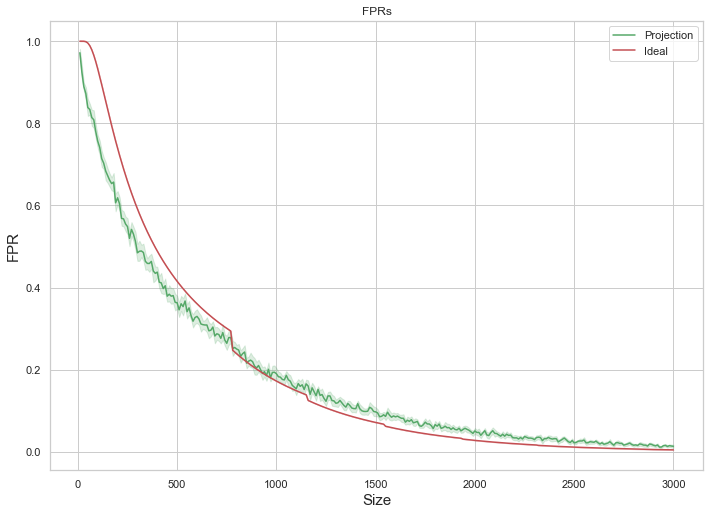

In [77]:
sns.set(rc={'figure.figsize':(11.7,8.27)},style="whitegrid")
sns.lineplot(x=size_values, y=fpr_values, err_style="band",label = "Projection",linewidth = 1.5,color="g")
sns.lineplot(x=size_values, y=y_ideal, err_style="band",label = "Ideal",linewidth = 1.5,color="r")
plt.title('FPRs')
plt.xlabel("Size", fontsize = 15)
plt.ylabel("FPR", fontsize = 15)
#plt.figure(figsize = (5000,5000))
plt.show()

In [78]:
average_fprs = num_of_iterations*average_fprs
print(len(average_fprs))

6000


In [79]:
average_times = num_of_iterations*average_times
print(len(average_times))

6000


In [80]:
print(average_fprs)

[0.9718, 0.9250000000000002, 0.8892, 0.8726, 0.8384, 0.8336, 0.8140000000000001, 0.8085999999999999, 0.7796000000000001, 0.7564, 0.7409999999999999, 0.7140000000000001, 0.7027999999999999, 0.6838, 0.6727999999999998, 0.6613999999999999, 0.6532, 0.6567999999999999, 0.6064, 0.6186, 0.6035999999999999, 0.5684, 0.5671999999999999, 0.5548000000000001, 0.5484, 0.5198, 0.5416000000000001, 0.53, 0.5124000000000002, 0.4846000000000001, 0.48840000000000006, 0.48900000000000005, 0.4854000000000001, 0.4638000000000001, 0.45879999999999993, 0.4586, 0.4635999999999999, 0.4402000000000001, 0.4346, 0.4376000000000001, 0.4130000000000001, 0.4114, 0.3976, 0.40440000000000004, 0.37900000000000006, 0.38380000000000003, 0.379, 0.38040000000000007, 0.36400000000000005, 0.36299999999999993, 0.34580000000000005, 0.3605999999999999, 0.3536, 0.36719999999999997, 0.3412, 0.3505999999999999, 0.33199999999999996, 0.31799999999999995, 0.32699999999999996, 0.3298, 0.32339999999999997, 0.3111999999999999, 0.309600000

In [81]:
saved_data = list(zip(size_values, y_ideal, fpr_values, average_fprs, times, average_times))
df = pd.DataFrame(saved_data,columns = ['Size of filter(bits)','Ideal FPR', 'Projection FPR for iteration', 'Average Projection FPR', 'Projection Filter Total Creation Time(sec)', 'Average Projection Filter Total Creation Time(sec)'])
df.head()

,Size of filter(bits),Ideal FPR,Projection FPR for iteration,Average Projection FPR,Projection Filter Total Creation Time(sec),Average Projection Filter Total Creation Time(sec)
0,10,1.000000,0.996,0.9718,0.108625,0.112259
1,20,0.999999,0.868,0.9250,0.088951,0.104290
2,30,0.999887,0.864,0.8892,0.162554,0.106985
3,40,0.998870,0.888,0.8726,0.086303,0.103798
4,50,0.995548,0.824,0.8384,0.084459,0.109729


In [32]:
df.to_csv('/Users/aditijain/Desktop/NewFolderWithItems/SURA/Diabetes_rerun_epochs_100.csv')